## Severity Grading of Knee Osteoarthritis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random
import sys
import seaborn as sns
from matplotlib.image import imread
import cv2

In [2]:
test_path='Data/test'
train_path='Data/train'
# val_path='Data/val'

### Exploratory Data Analysis (EDA)

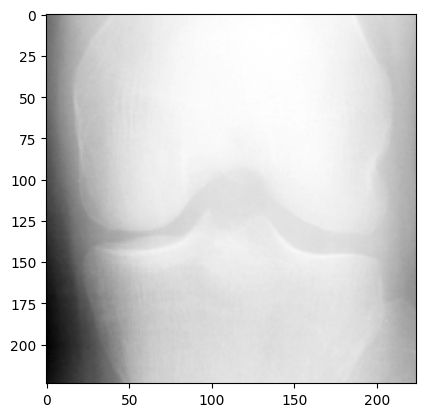

In [3]:
img=imread(train_path+'/healthy/'+os.listdir(train_path+'/healthy')[2])
plt.imshow(img,cmap='gray')

In [4]:
img.shape

(224, 224)

In [5]:
len(os.listdir(train_path))

3

In [6]:
len(os.listdir(train_path))

3

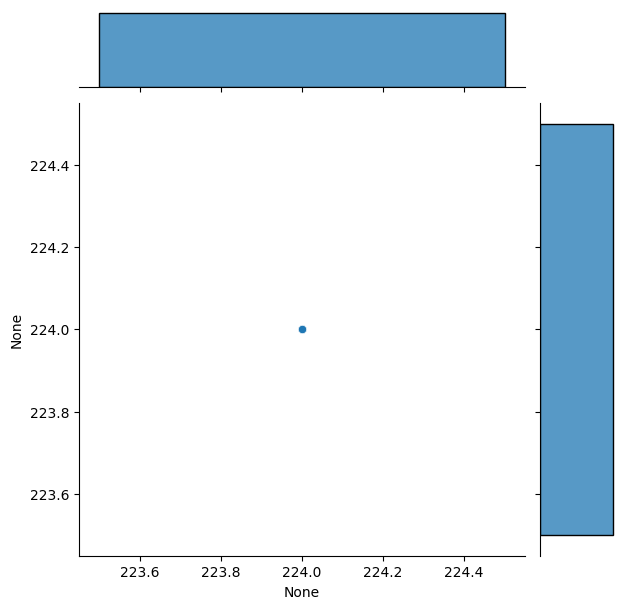

In [7]:
dim1 = []
dim2 = []
for image_filename in os.listdir(train_path+'/healthy')[:1000]:
    img = imread(train_path+'/healthy'+'/'+image_filename)
    d1,d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)
sns.jointplot(x=dim1,y=dim2)

In [8]:
image_shape = [224,224]

In [9]:
classes=['healthy','moderate','severe']
print(classes)

['healthy', 'moderate', 'severe']


In [10]:
data=0
total=0
for i in classes:
    for image_filename in os.listdir(train_path+'/'+str(i)):
        total+=1
        data+=1       
    
    print("Total number of images = ",data, "in class =",i)
    data=0

print("Total images = ",total)
print("Average no images = ",total//3)

Total number of images =  2286 in class = healthy
Total number of images =  757 in class = moderate
Total number of images =  173 in class = severe
Total images =  3216
Average no images =  1072


In [11]:
data=0
total=0
for i in classes:
    for image_filename in os.listdir(test_path+'/'+str(i)):
        total+=1
        data+=1       
    
    print("Total number of images = ",data, "in class =",i)
    data=0

print("Total images = ",total)
print("Average no images = ",total//3)

Total number of images =  639 in class = healthy
Total number of images =  223 in class = moderate
Total number of images =  51 in class = severe
Total images =  913
Average no images =  304


### Data Augmentation

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [13]:
image_gen = ImageDataGenerator(rotation_range=40, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allow horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

batch_size = 128

In [14]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape,
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               #save_to_dir='preview',
                                               #save_prefix='train',
                                               #save_format='png',
                                               shuffle=True)

len(train_image_gen.classes)

Found 3216 images belonging to 3 classes.


3216

In [15]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape,
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               #save_to_dir='preview',
                                               #save_prefix='test',
                                               #save_format='png',
                                               shuffle=False)

len(test_image_gen.classes)

Found 913 images belonging to 3 classes.


913

### Deep Learning

In [16]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from models import tf_models, plot_metrics

In [17]:
def store_results(model_name, y_true, y_pred, results_file='results.csv'):

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Prepare data row
    result_row = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    # Check if the file exists
    if os.path.exists(results_file):
        df = pd.read_csv(results_file)
    else:
        df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

    # Append new results
    df = pd.concat([df, pd.DataFrame([result_row])], ignore_index=True)

    # Save to CSV
    df.to_csv(results_file, index=False)

In [18]:
dl = tf_models(image_shape,classes)

#### VGG16 Model implementation and training

In [19]:
#VGG16 Model
VGG16_model = dl.VGG_16()
VGG16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 800)               20071200  
                                                                 
 dense_1 (Dense)             (None, 650)               520650    
                                                                 
 dropout (Dropout)           (None, 650)               0         
                                                                 
 dense_2 (Dense)             (None, 500)               325500    
                                                                 
 dense_3 (Dense)             (None, 350)               1

In [ ]:
# Train Model
VGG16_model.fit(train_image_gen,epochs=5,
                batch_size=batch_size,
                validation_data=test_image_gen)

Epoch 1/5
26/26 [==============================] - 95s 3s/step - loss: 0.8342 - accuracy: 0.6660 - val_loss: 0.7864 - val_accuracy: 0.6999
Epoch 2/5
26/26 [==============================] - 54s 2s/step - loss: 0.7549 - accuracy: 0.7090 - val_loss: 0.7415 - val_accuracy: 0.6999
Epoch 3/5
26/26 [==============================] - 52s 2s/step - loss: 0.7181 - accuracy: 0.7105 - val_loss: 0.6886 - val_accuracy: 0.6999
Epoch 4/5
26/26 [==============================] - 50s 2s/step - loss: 0.6431 - accuracy: 0.7108 - val_loss: 0.6635 - val_accuracy: 0.6999
Epoch 5/5
26/26 [==============================] - 59s 2s/step - loss: 0.5972 - accuracy: 0.7155 - val_loss: 0.5692 - val_accuracy: 0.7163


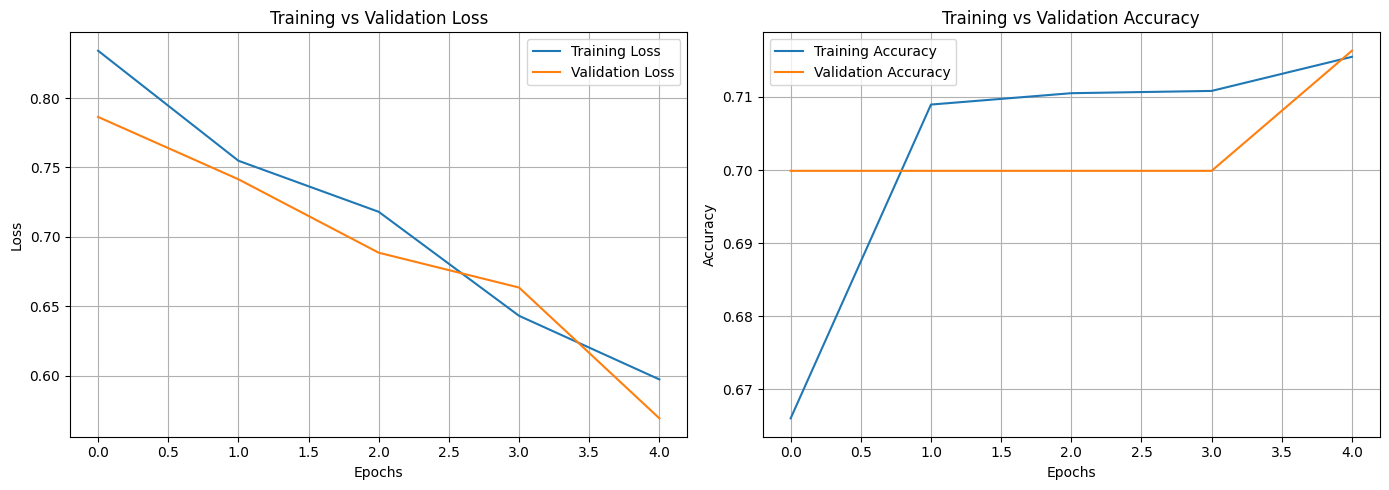

In [21]:
metrics = pd.DataFrame(VGG16_model.history.history)
plot_metrics(metrics)

In [22]:
predictions = np.argmax(VGG16_model.predict(test_image_gen), axis=1)
print(classification_report(test_image_gen.classes,predictions))

print(confusion_matrix(test_image_gen.classes,predictions))

8/8 [==============================] - 13s 2s/step
              precision    recall  f1-score   support

           0       0.72      0.99      0.84       639
           1       0.50      0.09      0.15       223
           2       0.00      0.00      0.00        51

    accuracy                           0.71       913
   macro avg       0.41      0.36      0.33       913
weighted avg       0.63      0.71      0.62       913

[[633   6   0]
 [204  19   0]
 [ 38  13   0]]


d:\Miniconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Miniconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Miniconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
store_results("VGG16",test_image_gen.classes,predictions)

C:\Users\Vincent-Isaac\AppData\Local\Temp\ipykernel_24248\3846233949.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([result_row])], ignore_index=True)


#### Custom built Model implementation and training

In [19]:
#Custom CNN model
custom_model = dl.customCNN()
custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 193600)            0         
                                                                 
 dense (Dense)               (None, 8)                 1

In [ ]:
# Train Model
custom_model.fit(train_image_gen,epochs=5,
                batch_size=batch_size,
                validation_data=test_image_gen )

Epoch 1/5
26/26 [==============================] - 49s 2s/step - loss: 0.9003 - accuracy: 0.7108 - val_loss: 0.7973 - val_accuracy: 0.6999
Epoch 2/5
26/26 [==============================] - 46s 2s/step - loss: 0.7622 - accuracy: 0.7108 - val_loss: 0.7791 - val_accuracy: 0.6999
Epoch 3/5
26/26 [==============================] - 45s 2s/step - loss: 0.7582 - accuracy: 0.7108 - val_loss: 0.7639 - val_accuracy: 0.6999
Epoch 4/5
26/26 [==============================] - 43s 2s/step - loss: 0.7535 - accuracy: 0.7108 - val_loss: 0.7608 - val_accuracy: 0.6999
Epoch 5/5
26/26 [==============================] - 45s 2s/step - loss: 0.7521 - accuracy: 0.7108 - val_loss: 0.7803 - val_accuracy: 0.6999


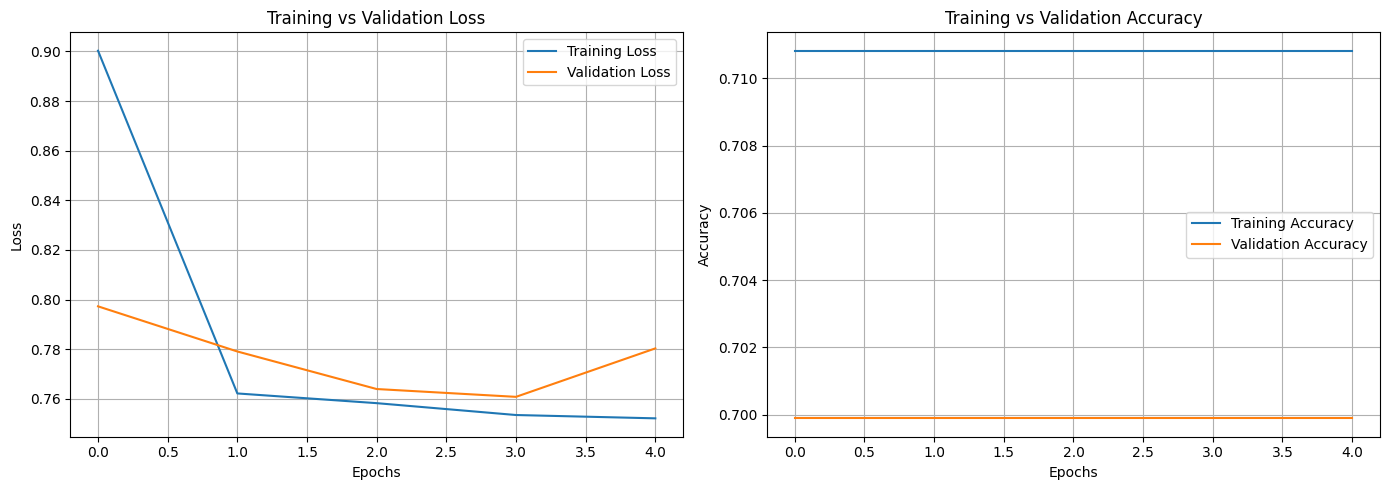

In [21]:
metrics = pd.DataFrame(custom_model.history.history)
plot_metrics(metrics)

In [22]:
predictions = np.argmax(custom_model.predict(test_image_gen), axis=1)
print(classification_report(test_image_gen.classes,predictions))

print(confusion_matrix(test_image_gen.classes,predictions))

8/8 [==============================] - 10s 1s/step
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       639
           1       0.00      0.00      0.00       223
           2       0.00      0.00      0.00        51

    accuracy                           0.70       913
   macro avg       0.23      0.33      0.27       913
weighted avg       0.49      0.70      0.58       913

[[639   0   0]
 [223   0   0]
 [ 51   0   0]]


d:\Miniconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Miniconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Miniconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
store_results("CustomCNN",test_image_gen.classes,predictions)

#### ResNet15 Model implementation and training

In [19]:
#ResNet15V2 model
Resnet_model = dl.ResNet15_V2()

Resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 2048)              58331648  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 58,594,307
Trainable params: 262,659
Non-trainable params: 58,331,648
_________________________________________________________________


In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
# Train Model
Resnet_model.fit(train_image_gen,
                validation_data=test_image_gen,
                epochs=20,
                callbacks=[learning_rate_reduction],
                verbose=1)

Epoch 1/20
26/26 [==============================] - 59s 2s/step - loss: 0.7098 - accuracy: 0.7211 - val_loss: 0.5678 - val_accuracy: 0.7503 - lr: 0.0010
Epoch 2/20
26/26 [==============================] - 48s 2s/step - loss: 0.5217 - accuracy: 0.7858 - val_loss: 0.4962 - val_accuracy: 0.7853 - lr: 0.0010
Epoch 3/20
26/26 [==============================] - 47s 2s/step - loss: 0.4731 - accuracy: 0.8075 - val_loss: 0.4698 - val_accuracy: 0.8028 - lr: 0.0010
Epoch 4/20
26/26 [==============================] - 48s 2s/step - loss: 0.4620 - accuracy: 0.8156 - val_loss: 0.4572 - val_accuracy: 0.8116 - lr: 0.0010
Epoch 5/20
26/26 [==============================] - 50s 2s/step - loss: 0.4408 - accuracy: 0.8175 - val_loss: 0.4362 - val_accuracy: 0.8313 - lr: 0.0010
Epoch 6/20
26/26 [==============================] - 48s 2s/step - loss: 0.4254 - accuracy: 0.8156 - val_loss: 0.4469 - val_accuracy: 0.8215 - lr: 0.0010
Epoch 7/20
26/26 [==============================] - 51s 2s/step - loss: 0.4211 - a

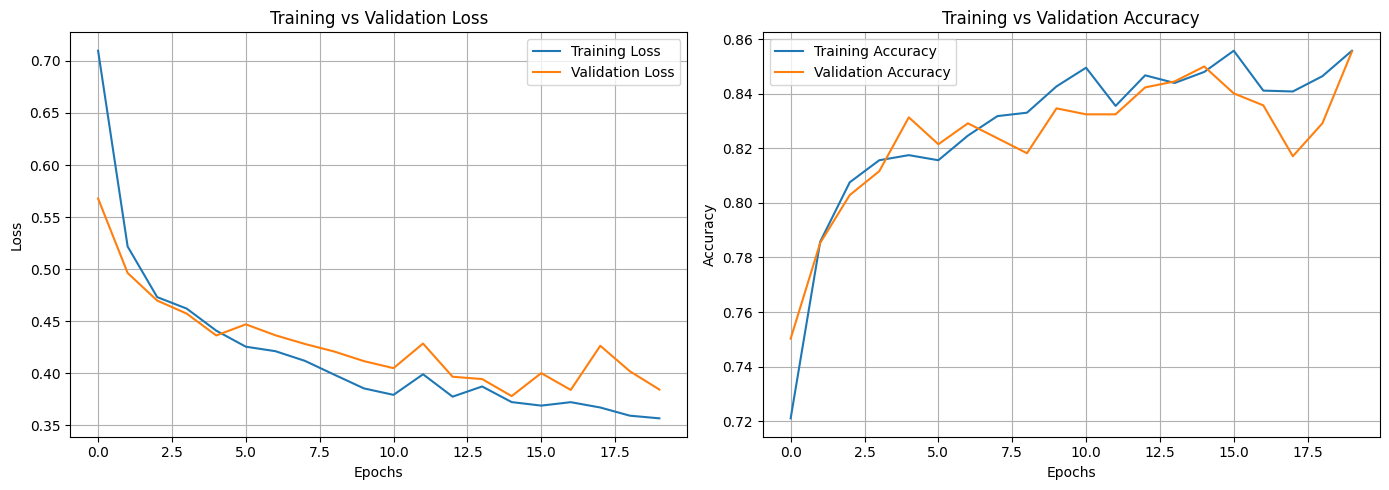

In [22]:
metrics = pd.DataFrame(Resnet_model.history.history)
plot_metrics(metrics)

In [23]:
predictions = np.argmax(Resnet_model.predict(test_image_gen), axis=1)

print(classification_report(test_image_gen.classes,predictions))

print(confusion_matrix(test_image_gen.classes,predictions))

8/8 [==============================] - 13s 1s/step
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       639
           1       0.69      0.61      0.65       223
           2       0.80      0.31      0.45        51

    accuracy                           0.84       913
   macro avg       0.79      0.63      0.67       913
weighted avg       0.83      0.84      0.82       913

[[610  28   1]
 [ 83 137   3]
 [  2  33  16]]


In [24]:
store_results("ResNet15V2",test_image_gen.classes,predictions)

In [ ]:
# Save Model
# Resnet_model.save('Resnet.h5')

#### EfficientNetB5 model


In [19]:
#EfficientNetB5 model
B5_model = dl.EfficientNet_B5()

B5_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 29,047,034
Trainable params: 529,411
Non-trainable params: 28,517,623
______________________________________

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
# Train Model
B5_model.fit(train_image_gen,
                validation_data=test_image_gen,
                epochs=20,
                callbacks=[learning_rate_reduction],
                verbose=1)

Epoch 1/20
26/26 [==============================] - 75s 2s/step - loss: 9.7632 - accuracy: 0.5905 - val_loss: 23.3952 - val_accuracy: 0.6999 - lr: 0.0010
Epoch 2/20
26/26 [==============================] - 58s 2s/step - loss: 7.5213 - accuracy: 0.6231 - val_loss: 11.5738 - val_accuracy: 0.0559 - lr: 0.0010
Epoch 3/20
26/26 [==============================] - 47s 2s/step - loss: 6.1803 - accuracy: 0.6440 - val_loss: 8.7778 - val_accuracy: 0.6999 - lr: 0.0010
Epoch 4/20
26/26 [==============================] - ETA: 0s - loss: 5.0505 - accuracy: 0.6486
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
26/26 [==============================] - 50s 2s/step - loss: 5.0505 - accuracy: 0.6486 - val_loss: 5.5963 - val_accuracy: 0.6999 - lr: 0.0010
Epoch 5/20
26/26 [==============================] - 48s 2s/step - loss: 4.3318 - accuracy: 0.6863 - val_loss: 4.8007 - val_accuracy: 0.6999 - lr: 5.0000e-04
Epoch 6/20
26/26 [==============================] - 48s 2s/step - loss

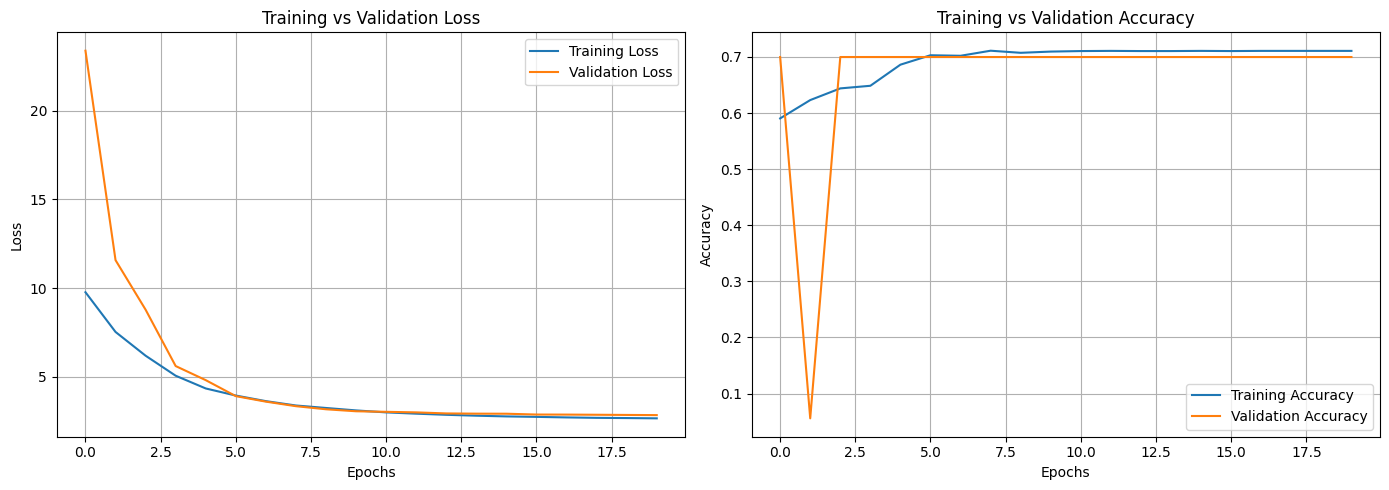

In [22]:
metrics = pd.DataFrame(B5_model.history.history)
plot_metrics(metrics)

In [23]:
predictions = np.argmax(B5_model.predict(test_image_gen), axis=1)

print(classification_report(test_image_gen.classes,predictions))

print(confusion_matrix(test_image_gen.classes,predictions))

8/8 [==============================] - 15s 1s/step
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       639
           1       0.00      0.00      0.00       223
           2       0.00      0.00      0.00        51

    accuracy                           0.70       913
   macro avg       0.23      0.33      0.27       913
weighted avg       0.49      0.70      0.58       913

[[639   0   0]
 [223   0   0]
 [ 51   0   0]]


d:\Miniconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Miniconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Miniconda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
store_results("EfficientNetB5",test_image_gen.classes,predictions)

In [ ]:
# Save Model
#B5_model.save('EficientNet.h5')

### Results

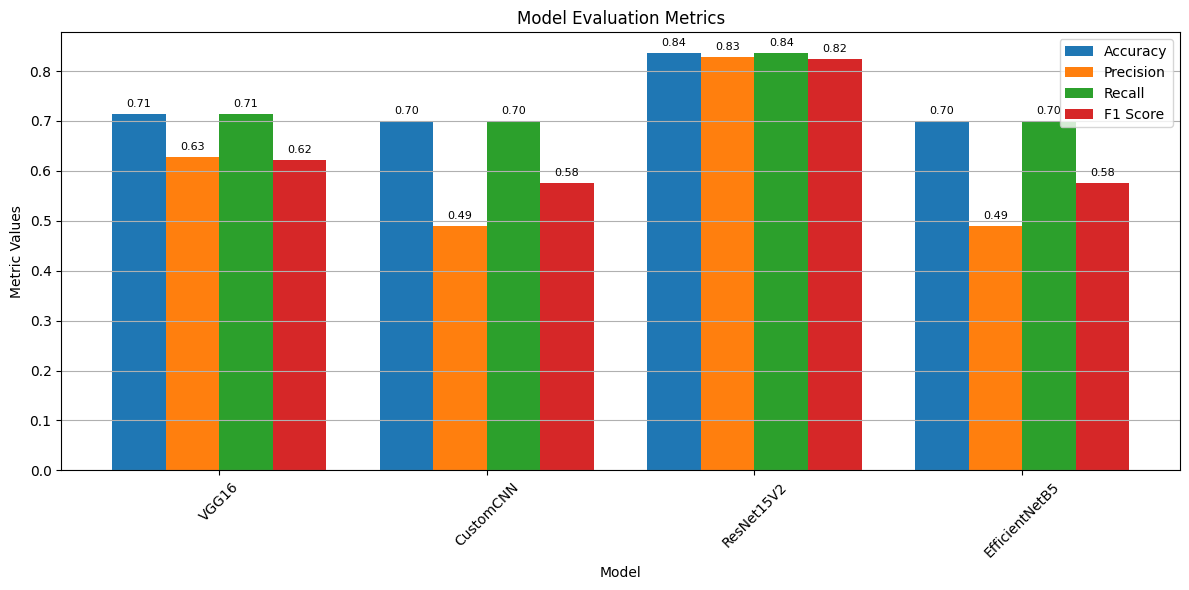

In [26]:
def plot_model_results(results_file='results.csv'):

    df = pd.read_csv(results_file)

    # Set metrics to plot
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Bar width and positions
    bar_width = 0.2
    x = range(len(df['Model']))
    for i, metric in enumerate(metrics):
        ax.bar(
            [pos + i * bar_width for pos in x],
            df[metric],
            width=bar_width,
            label=metric
        )

    # X-axis settings
    ax.set_xticks([pos + 1.5 * bar_width for pos in x])
    ax.set_xticklabels(df['Model'], rotation=45)
    ax.set_title('Model Evaluation Metrics')
    ax.set_ylabel('Metric Values')
    ax.set_xlabel('Model')
    ax.legend()
    ax.grid(axis='y')

    # Annotate values
    for i, metric in enumerate(metrics):
        for j, val in enumerate(df[metric]):
            ax.text(j + i * bar_width, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

plot_model_results()